# Final Project Medical Imaging
Alejandro Cedillo Gamez

In [1]:
import os
import pydicom
import numpy as np

## Cancer segmentation rotation gif

In [2]:
# data folder with DICOM files
ct_folder = "1196/30_EQP_Ax5.00mm/"

In [3]:
# Load DICOM files
files = [os.path.join(ct_folder, f) for f in os.listdir(ct_folder)]
datasets = []
for f in files:
    try:
        ds = pydicom.dcmread(f)
        # img slices only
        if hasattr(ds, "PixelData"):
            datasets.append(ds)
    except Exception as e:
        # the rest we skip
        continue

# Sort by the Z coordinate 
datasets.sort(key=lambda ds: float(ds.ImagePositionPatient[2]))

# Stack into a 3D NumPy array
ct_slices = [ds.pixel_array for ds in datasets]
ct_volume = np.stack(ct_slices, axis=0)  # (num_slices, rows, cols)

# Record slice positions for later
z_positions = [float(ds.ImagePositionPatient[2]) for ds in datasets]

print(f"Loaded CT volume with shape {ct_volume.shape}")


Loaded CT volume with shape (52, 512, 512)


In [69]:
ds

Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 180
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.2.840.113619.2.5.34343107.11676.1605770289.74
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002,0013) Implementation Version Name         SH: 'dcm4che-1.4-JP'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 192'
(0008,0008) Image Type                          CS: ['DERIVED', 'SECONDARY', 'REFORMATTED', 'AVERAGE']
(0008,0012) Instance Creation Date              DA: ''
(0008,0013) Instance Creation Time              TM: '110241'
(0008,0016) SOP Class UID                       UI: CT Image Storage
(0008,0017) Acquisition UID              

In [70]:
# 2.2 List all attribute names (keywords)
print(ds.dir())

# 2.3 Iterate through every element and print tag, name, and value
for elem in ds:
    print(elem.tag, elem.name, "=", elem.value)

['AccessionNumber', 'AcquisitionDate', 'AcquisitionNumber', 'AcquisitionTime', 'AcquisitionUID', 'BitsAllocated', 'BitsStored', 'Columns', 'ContentDate', 'ContentTime', 'ConvolutionKernel', 'DataCollectionDiameter', 'DeidentificationMethod', 'DeidentificationMethodCodeSequence', 'ExposureTime', 'FillerOrderNumberImagingServiceRequest', 'FrameOfReferenceUID', 'GantryDetectorTilt', 'HighBit', 'ImageOrientationPatient', 'ImagePositionPatient', 'ImageType', 'InstanceCreationDate', 'InstanceCreationTime', 'InstanceNumber', 'KVP', 'LongitudinalTemporalInformationModified', 'Manufacturer', 'ManufacturerModelName', 'Modality', 'NumberOfFrames', 'PatientAge', 'PatientBirthDate', 'PatientID', 'PatientIdentityRemoved', 'PatientName', 'PatientPosition', 'PatientSex', 'PhotometricInterpretation', 'PixelData', 'PixelRepresentation', 'PixelSpacing', 'PositionReferenceIndicator', 'ProcedureCodeSequence', 'ReconstructionDiameter', 'ReferringPhysicianName', 'RescaleIntercept', 'RescaleSlope', 'RescaleTy

In [71]:
labels = ds.pixel_array

# list all unique label values
uniques = np.unique(labels)
print("Unique labels in SEG:", uniques)

Unique labels in SEG: [-1024 -1023 -1022 ...  1618  1673  1728]


In [ ]:
# Load the segmentation file
seg_file = "1196/10_AP_Ax5.00mm_ManualROI_Tumor.dcm"


In [9]:
seg_ds = pydicom.dcmread(seg_file)

# Extract the raw mask frames
# we get (num_frames, rows, cols)
mask_array = seg_ds.pixel_array  
print("Mask array shape:", mask_array.shape)
print("Unique values in mask:", np.unique(mask_array))

# Get each frame’s slice location (Z‑position)
frame_positions = [
    float(frame.PlanePositionSequence[0].ImagePositionPatient[2])
    for frame in seg_ds.PerFrameFunctionalGroupsSequence
]
print("First 5 frame Z‑positions:", frame_positions[:5])

Mask array shape: (19, 512, 512)
Unique values in mask: [0 1]
First 5 frame Z‑positions: [-182.0, -162.0, -157.0, -152.0, -147.0]


In [20]:
# Make an empty volume the same shape as ct_volume
mask_volume = np.zeros_like(ct_volume, dtype=bool)

In [ ]:
# Convert z_positions to a NumPy array for better handling
ct_z = np.array(z_positions)

for f, frame_z in enumerate(frame_positions):
    # Find the CT slice whose Z is closest to this frame's Z
    slice_idx = int(np.argmin(np.abs(ct_z - frame_z)))
    # Insert this 2D mask into that slice
    mask_volume[slice_idx, :, :] = mask_array[f] > 0  # True where tumor


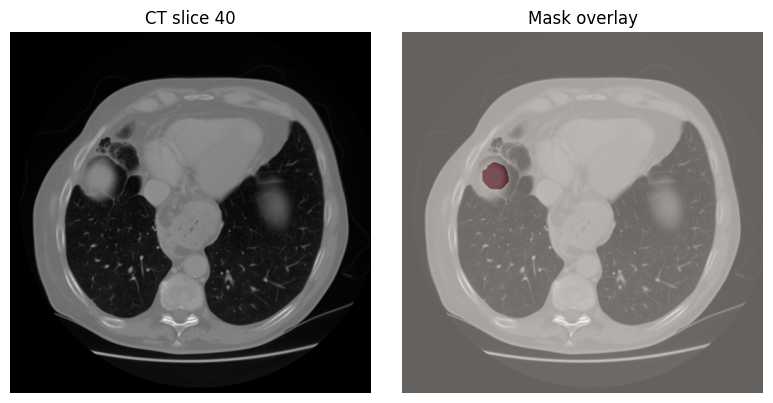

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

z0 = slice_idx  

ct_slice  = ct_volume[z0]
mask_slice = mask_volume[z0]  

plt.figure(figsize=(8,4))

# 1) Plot the CT in gray
plt.subplot(1,2,1)
plt.title(f"CT slice {z0}")
plt.imshow(ct_slice, cmap='gray')
plt.axis('off')

# Plot CT again, with mask in red
plt.subplot(1,2,2)
plt.title("Mask overlay")
plt.imshow(ct_slice, cmap='gray')
plt.imshow(mask_slice, cmap='Reds', alpha=0.4)  
plt.axis('off')
plt.tight_layout()
plt.show()


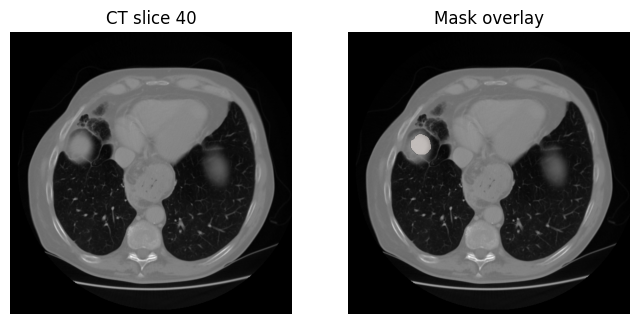

In [41]:
# Attempt 2 of plotting the mask overlay
z0 = slice_idx  
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title(f"CT slice {z0}")
plt.imshow(ct_volume[z0], cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Mask overlay")
plt.imshow(ct_volume[z0], cmap='gray')
plt.imshow(np.ma.masked_where(~mask_volume[z0], mask_volume[z0]), 
           cmap='Reds', alpha=0.5)
plt.axis('off')

plt.show()


In [ ]:
import scipy
# copied functions from the activity 3 notebook
def rotate_on_axial_plane(img_dcm: np.ndarray, angle_in_degrees: float) -> np.ndarray:
    """ Rotate the image on the axial plane. """
    return scipy.ndimage.rotate(img_dcm, angle_in_degrees, axes=(1, 2), reshape=False)

def MIP_sagittal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the maximum intensity projection on the sagittal orientation. """
    return np.max(img_dcm, axis=2)


In [ ]:
angles = np.linspace(0, 360, num=36, endpoint=False)
projections = []
for angle in angles:
    # spin both CT and mask around z‑axis
    ct_rot   = rotate_on_axial_plane(ct_volume,   angle)
    mask_rot = rotate_on_axial_plane(mask_volume, angle)
    # compute the sagittal MIP of each
    proj_ct   = MIP_sagittal_plane(ct_rot)
    proj_mask = MIP_sagittal_plane(mask_rot) > 0
    projections.append((proj_ct, proj_mask))


MovieWriter ffmpeg unavailable; using Pillow instead.


Saved results/MIP/rotating_MIP.gif


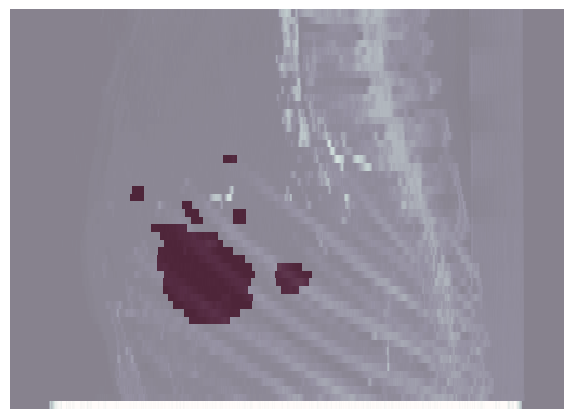

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Prepare your colormap + intensity window
img_min, img_max = np.min(ct_volume), np.max(ct_volume)
cm = plt.colormaps['bone']

# 2) Compute mm spacing for your sagittal MIP:
#    - vertical (rows of proj): slice thickness in mm
#    - horizontal (cols of proj): pixel spacing in mm (x‑direction)
slice_thickness = abs(z_positions[1] - z_positions[0])
pixel_spacing_x, pixel_spacing_y = datasets[0].PixelSpacing
pixel_len_mm = [slice_thickness, pixel_spacing_x]

os.makedirs('results/MIP', exist_ok=True)

# Save each projection as a PNG
for idx, (proj_ct, proj_mask) in enumerate(projections):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.imshow(proj_ct,
              cmap=cm,
              vmin=img_min, vmax=img_max,
              aspect=pixel_len_mm[0] / pixel_len_mm[1],
              interpolation='nearest')
    ax.imshow(proj_mask,
              cmap='Reds',
              alpha=0.4,
              aspect=pixel_len_mm[0] / pixel_len_mm[1],
              interpolation='nearest')
    ax.axis('off')
    plt.tight_layout(pad=0)
    plt.savefig(f'results/MIP/Projection_{idx:02d}.png', bbox_inches='tight')
    plt.close(fig)

fig, ax = plt.subplots(figsize=(6,4))
ax.axis('off')
plt.tight_layout(pad=0)

animation_frames = []
for proj_ct, proj_mask in projections:
    im_ct   = ax.imshow(proj_ct,
                        cmap=cm,
                        vmin=img_min, vmax=img_max,
                        aspect=pixel_len_mm[0] / pixel_len_mm[1],
                        interpolation='nearest',
                        animated=True)
    im_mask = ax.imshow(proj_mask,
                        cmap='Reds',
                        alpha=0.4,
                        aspect=pixel_len_mm[0] / pixel_len_mm[1],
                        interpolation='nearest',
                        animated=True)
    animation_frames.append([im_ct, im_mask])

#  Save out the rotating MIP GIF
anim = animation.ArtistAnimation(
    fig,
    animation_frames,
    interval=100,   # ms between frames (10 fps)
    blit=True
)
anim.save('results/MIP/rotating_MIP.gif')
print("Saved results/MIP/rotating_MIP.gif")


## Liver segmentation gif

In [60]:
# data folder with DICOM files
ct_folder = "1196/10_AP_Ax5.00mm/"

In [61]:
# Load DICOM files
files = [os.path.join(ct_folder, f) for f in os.listdir(ct_folder)]
datasets = []
for f in files:
    try:
        ds = pydicom.dcmread(f)
        # img slices only
        if hasattr(ds, "PixelData"):
            datasets.append(ds)
    except Exception as e:
        # the rest we skip
        continue

# Sort by the Z coordinate 
datasets.sort(key=lambda ds: float(ds.ImagePositionPatient[2]))

# Stack into a 3D NumPy array
ct_slices = [ds.pixel_array for ds in datasets]
ct_volume = np.stack(ct_slices, axis=0)  # (num_slices, rows, cols)

# Record slice positions for later
z_positions = [float(ds.ImagePositionPatient[2]) for ds in datasets]

print(f"Loaded CT volume with shape {ct_volume.shape}")


Loaded CT volume with shape (52, 512, 512)


In [62]:
# Load the segmentation file
seg_file = "1196/10_AP_Ax5.00mm_ManualROI_Liver.dcm"

In [63]:
seg_ds = pydicom.dcmread(seg_file)

# Extract the raw mask frames
# we get (num_frames, rows, cols)
mask_array = seg_ds.pixel_array  
print("Mask array shape:", mask_array.shape)
print("Unique values in mask:", np.unique(mask_array))

# Get each frame’s slice location (Z‑position)
frame_positions = [
    float(frame.PlanePositionSequence[0].ImagePositionPatient[2])
    for frame in seg_ds.PerFrameFunctionalGroupsSequence
]
print("First 5 frame Z‑positions:", frame_positions[:5])

Mask array shape: (31, 512, 512)
Unique values in mask: [0 1]
First 5 frame Z‑positions: [-227.0, -222.0, -217.0, -212.0, -207.0]


In [64]:
# Make an empty volume the same shape as ct_volume
mask_volume = np.zeros_like(ct_volume, dtype=bool)

In [65]:
# Convert z_positions to a NumPy array for better handling
ct_z = np.array(z_positions)

for f, frame_z in enumerate(frame_positions):
    # Find the CT slice whose Z is closest to this frame's Z
    slice_idx = int(np.argmin(np.abs(ct_z - frame_z)))
    # Insert this 2D mask into that slice
    mask_volume[slice_idx, :, :] = mask_array[f] > 0  # True where tumor


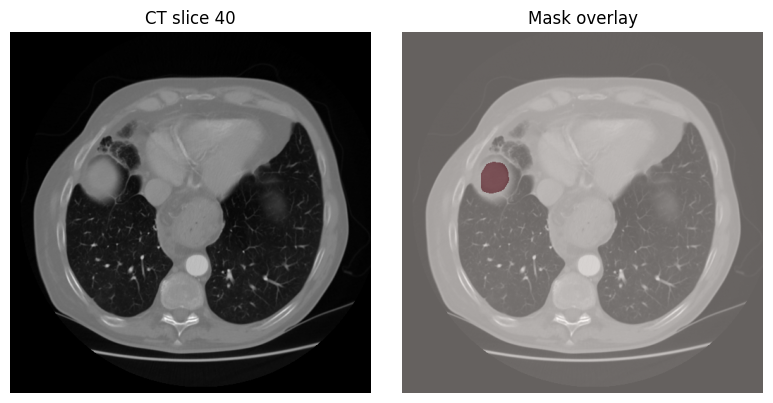

In [66]:
import matplotlib.pyplot as plt
import numpy as np

z0 = slice_idx  

ct_slice  = ct_volume[z0]
mask_slice = mask_volume[z0]  

plt.figure(figsize=(8,4))

# 1) Plot the CT in gray
plt.subplot(1,2,1)
plt.title(f"CT slice {z0}")
plt.imshow(ct_slice, cmap='gray')
plt.axis('off')

# Plot CT again, with mask in red
plt.subplot(1,2,2)
plt.title("Mask overlay")
plt.imshow(ct_slice, cmap='gray')
plt.imshow(mask_slice, cmap='Reds', alpha=0.4)  
plt.axis('off')
plt.tight_layout()
plt.show()


In [67]:
angles = np.linspace(0, 360, num=36, endpoint=False)
projections = []
for angle in angles:
    # spin both CT and mask around z‑axis
    ct_rot   = rotate_on_axial_plane(ct_volume,   angle)
    mask_rot = rotate_on_axial_plane(mask_volume, angle)
    # compute the sagittal MIP of each
    proj_ct   = MIP_sagittal_plane(ct_rot)
    proj_mask = MIP_sagittal_plane(mask_rot) > 0
    projections.append((proj_ct, proj_mask))


MovieWriter ffmpeg unavailable; using Pillow instead.


Saved results/MIP/rotating_MIP2.gif


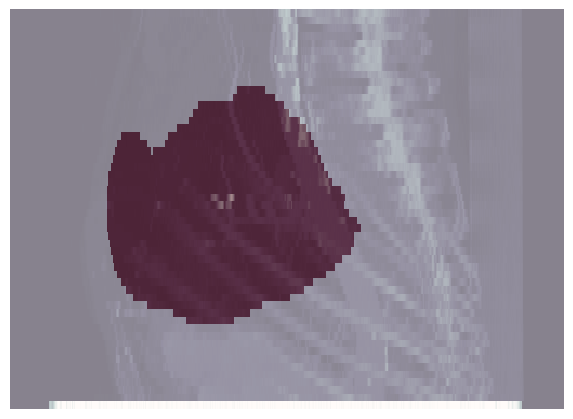

In [68]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Prepare your colormap + intensity window
img_min, img_max = np.min(ct_volume), np.max(ct_volume)
cm = plt.colormaps['bone']

# 2) Compute mm spacing for your sagittal MIP:
#    - vertical (rows of proj): slice thickness in mm
#    - horizontal (cols of proj): pixel spacing in mm (x‑direction)
slice_thickness = abs(z_positions[1] - z_positions[0])
pixel_spacing_x, pixel_spacing_y = datasets[0].PixelSpacing
pixel_len_mm = [slice_thickness, pixel_spacing_x]

os.makedirs('results/MIP', exist_ok=True)

# Save each projection as a PNG
for idx, (proj_ct, proj_mask) in enumerate(projections):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.imshow(proj_ct,
              cmap=cm,
              vmin=img_min, vmax=img_max,
              aspect=pixel_len_mm[0] / pixel_len_mm[1],
              interpolation='nearest')
    ax.imshow(proj_mask,
              cmap='Reds',
              alpha=0.4,
              aspect=pixel_len_mm[0] / pixel_len_mm[1],
              interpolation='nearest')
    ax.axis('off')
    plt.tight_layout(pad=0)
    plt.savefig(f'results/MIP/Projection_{idx:02d}.png', bbox_inches='tight')
    plt.close(fig)

fig, ax = plt.subplots(figsize=(6,4))
ax.axis('off')
plt.tight_layout(pad=0)

animation_frames = []
for proj_ct, proj_mask in projections:
    im_ct   = ax.imshow(proj_ct,
                        cmap=cm,
                        vmin=img_min, vmax=img_max,
                        aspect=pixel_len_mm[0] / pixel_len_mm[1],
                        interpolation='nearest',
                        animated=True)
    im_mask = ax.imshow(proj_mask,
                        cmap='Reds',
                        alpha=0.4,
                        aspect=pixel_len_mm[0] / pixel_len_mm[1],
                        interpolation='nearest',
                        animated=True)
    animation_frames.append([im_ct, im_mask])

#  Save out the rotating MIP GIF
anim = animation.ArtistAnimation(
    fig,
    animation_frames,
    interval=100,   # ms between frames (10 fps)
    blit=True
)
anim.save('results/MIP/rotating_MIP2.gif')
print("Saved results/MIP/rotating_MIP2.gif")
